# IMPORTS

In [108]:
import numpy as np
from datetime import datetime
from pathlib import Path
from IPython.display import clear_output
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import load_model
from visualkeras import layered_view
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle

from gand.config import MLConfig
from gand.data import data
from gand.models import models, architecture
from gand.visualisation import visualise
from gand.preprocessing import utils

import pandas as pd
from tabulate import tabulate
from tqdm.keras import TqdmCallback

from sklearn.metrics import classification_report


In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
dataset = mnist
EPOCHS = 100
BATCH_SIZE = MLConfig.BATCH_SIZE

loss = "categorical_crossentropy"
opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.0001, momentum=0.9)
metrics = ["accuracy"]

g_model_mnist = load_model(Path.cwd() / 'notebooks/models/cgan/mnist/gen_model_e-200.h5')
g_model_fashion_mnist = load_model(Path.cwd() / 'notebooks/models/cgan/fashion_mnist/gen_model_e-536.h5')
g_model_cifar10 = load_model(Path.cwd() / 'notebooks/models/cgan/cifar10/gen_model_e-553.h5')
g_model = g_model_mnist

train_with_gan = False
imbalance_data = False
train_type = 0

In [198]:
name = 'normal'
if train_with_gan:
    name = 'gans'
elif imbalance_data:
    name = 'imbalanced'

MLConfig.TYPE_NAMES = [f'{name}']
print(MLConfig.TYPE_NAMES)

['gans']


# Data Processing

### GAN Data

In [199]:
X_train_gan, y_train_gan = None, None
if train_with_gan:
    imbalance_data = True
    # GAN DATA
    n = 4000
    X_train_gan, y_train_gan = data.generate_fake_data(n=n, g_model=g_model, seed=10, verbose=1)
    X_train_gan, y_train_gan = utils.preprocess_data(X_train_gan, y_train_gan, val_255=False, exp_dims=False)
    
    print(X_train_gan.min(), X_train_gan.max(), X_train_gan.shape, y_train_gan.shape)

1250/1250 [==============================] - 18s 15ms/step
0.0 1.0 (40000, 28, 28, 1) (40000, 10)


### Normal Data

In [211]:
((X_train_real, y_train_real), (X_test_real, y_test_real)), dataset_name = data.load_dataset(dataset, return_name=True)
print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape, dataset_name)

exp_dims = False
if len(X_train_real.shape) == 3:
    exp_dims = True


print(X_train_real.min(), X_train_real.max(), X_test_real.min(), X_test_real.max())

X_train_real, y_train_real = utils.preprocess_data(X_train_real, y_train_real, exp_dims=exp_dims)
X_test_real, y_test_real = utils.preprocess_data(X_test_real, y_test_real, exp_dims=exp_dims)

print(X_train_real.min(), X_train_real.max(), X_test_real.min(), X_test_real.max())
print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape, dataset_name)

if imbalance_data:
    # REMOVING 50%
    keep_per_class = 2000
    # keep_per_class = (X_train_real.shape[0] // (4 * 10))
    X_train_removed, y_train_removed = [], []
    for i in range(y_train_real.shape[-1]):
        class_idx = np.where(np.argmax(y_train_real, axis=-1) == i)[0]
        selected_idx = np.random.choice(class_idx, keep_per_class)
        X_train_removed.append(X_train_real[selected_idx])
        y_train_removed.append(y_train_real[selected_idx])
    
    X_train_real, y_train_real = np.concatenate(X_train_removed, axis=0), np.concatenate(y_train_removed, axis=0)
print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape, dataset_name)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,) mnist
0 255 0 255
0.0 1.0 0.0 1.0
(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10) mnist
(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10) mnist


### Appending GAN Data

In [201]:
if train_with_gan:
    X_train_real = np.concatenate((X_train_real, X_train_gan), axis=0)
    y_train_real = np.concatenate((y_train_real, y_train_gan), axis=0)
    print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape, dataset_name)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10) mnist


### Shuffle It

In [202]:
X_train_real, y_train_real = shuffle(X_train_real, y_train_real)
X_test_real, y_test_real = shuffle(X_test_real, y_test_real)
print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape, dataset_name)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10) mnist


### Make it Faster

In [203]:
train_data = tf.data.Dataset.from_tensor_slices((X_train_real, y_train_real))
test_data = tf.data.Dataset.from_tensor_slices((X_test_real, y_test_real))

train_data = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_data, test_data, dataset_name

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 'mnist')

In [204]:
MLConfig.TYPE_NAMES[train_type], X_train_real.shape[1:]

('gans', (28, 28, 1))

In [205]:
model = architecture.deep_model(img_shape=X_train_real.shape[1:])
model.compile(loss=loss, optimizer=opt, metrics=metrics)
model.name, EPOCHS, BATCH_SIZE

('deep_model_stable', 100, 128)

# Fitting the Model

In [206]:
history = model.fit(train_data, batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, validation_data=test_data, verbose=0, 
                    callbacks=[TqdmCallback(verbose=1)], shuffle=True)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

## Saving Evaluations

In [207]:
eval_data = ((X_train_real, y_train_real), (X_test_real, y_test_real))
models.save_metrics(dataset_name=dataset_name, train_type=train_type,
                   epochs=EPOCHS, model=model, eval_data=eval_data, 
                   history=history)

## Saving History

In [208]:
history_path = Path.cwd() / f'reports/history/{dataset_name}/{MLConfig.TYPE_NAMES[train_type]}/E_{EPOCHS:03d}/'
history_path.mkdir(parents=True, exist_ok=True)
pd.DataFrame.from_dict(history.history).to_csv(history_path / f'{model.name}.csv',index=False)

# Visualisation

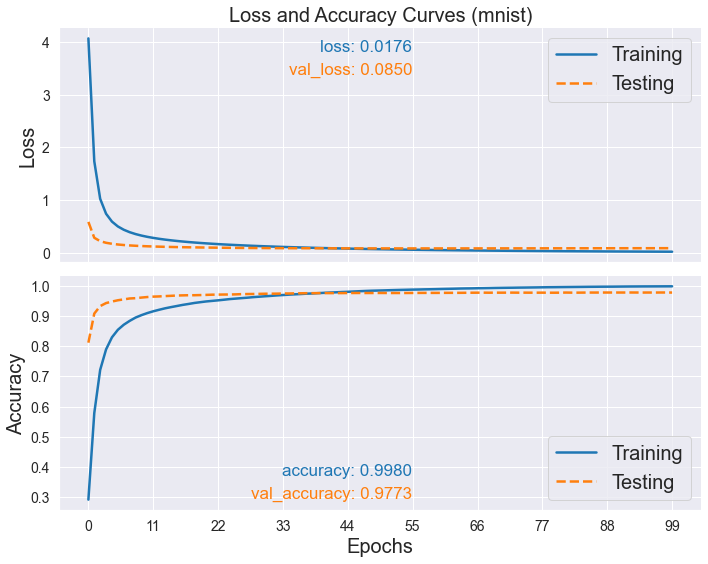

In [209]:
visualise.metric_plot(show_fig=True, history=history, dataset_name=dataset_name, 
                      savefig=False, epochs=EPOCHS)

# Evaluation

In [142]:
# model = load_model(Path.cwd() / Path(f'reports/models/{dataset_name}/{MLConfig.TYPE_NAMES[train_type]}/E_{EPOCHS:03d}/{model.name}.h5'))
# model.name

In [212]:
_, acc = model.evaluate(X_train_real, y_train_real)
_, acc = model.evaluate(X_test_real, y_test_real)

y_pred = np.argmax(model.predict(X_train_real), axis=-1)
report = classification_report(np.argmax(y_train_real, axis=1), y_pred)
print(report)

y_pred = np.argmax(model.predict(X_test_real), axis=-1)
report = classification_report(np.argmax(y_test_real, axis=1), y_pred)
print(report)

1875/1875 [==============================] - 9s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5923
           1       0.99      0.98      0.99      6742
           2       0.97      0.98      0.97      5958
           3       0.98      0.98      0.98      6131
           4       0.98      0.97      0.98      5842
           5       0.99      0.98      0.98      5421
           6       0.98      0.99      0.98      5918
           7       0.98      0.96      0.97      6265
           8       0.96      0.98      0.97      5851
           9       0.94      0.97      0.96      5949

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000

313/313 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       1